# 複数のアクションを推薦する意思決定モデル

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
from sklearn.utils import check_random_state
import torch

from estimators import calc_cavg, calc_cips, calc_cdr
from utils import generate_synthetic_data, eps_greedy_policy, calc_true_value ,aggregate_simulation_results

plt.style.use('ggplot')

# Off-Policy Evaluation

### ログデータのサイズ **n** を変化させる

In [2]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
num_actions = 20 # 行動数, |A|
beta = -3 # データ収集方策のパラメータ
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000] # データ収集方策が収集したログデータのサイズ
k = 10    # 行動の組み合わせの要素の数

In [3]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for num_data in num_data_list:
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,  
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k, random_policy=True
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["ips"] = calc_cips(offline_logged_data, pi)
        
        estimated_policy_values["dr"] = calc_cdr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)

num_data=8000...: 100%|██████████| 500/500 [12:13<00:00,  1.47s/it]


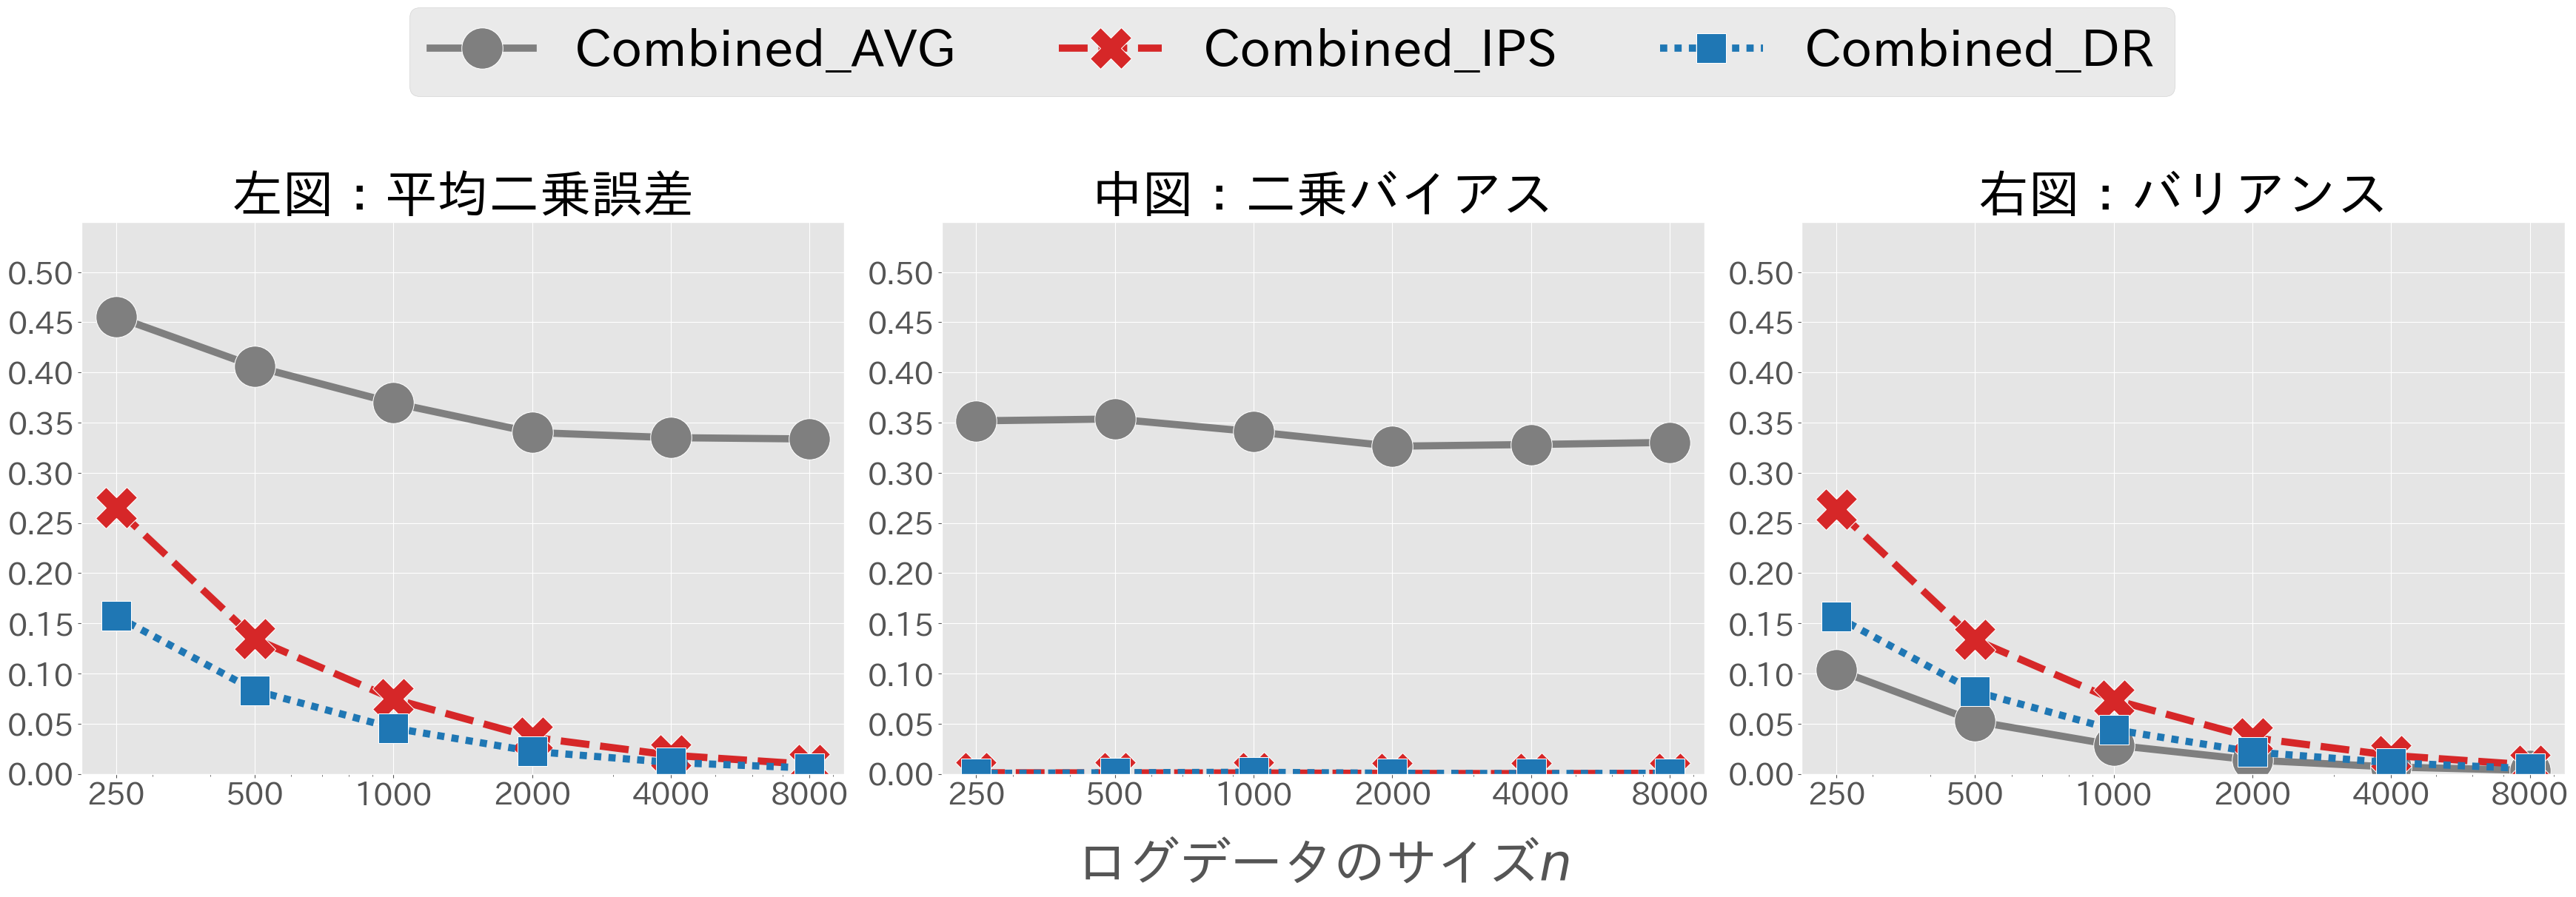

In [4]:
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        #palette=["tab:grey", "tab:red"],
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.55)
    ax.set_yticks(np.arange(0.0,0.55,0.05))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Combined_AVG", "Combined_IPS", "Combined_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

### ログデータの行動数 **#A** を変化させる

In [10]:
## シミュレーション設定
num_runs = 5000# シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
num_data = 1000 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [25, 50, 100, 200, 400, 800, 1600] # 行動数, |A|
k = 10

In [11]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出


for num_actions in num_actions_list:
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,  
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k, random_policy=True
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["new_ips"] = calc_cips(offline_logged_data, pi)
        
        estimated_policy_values["new_dr"] = calc_cdr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=1600...: 100%|██████████| 5000/5000 [1:20:38<00:00,  1.03it/s]


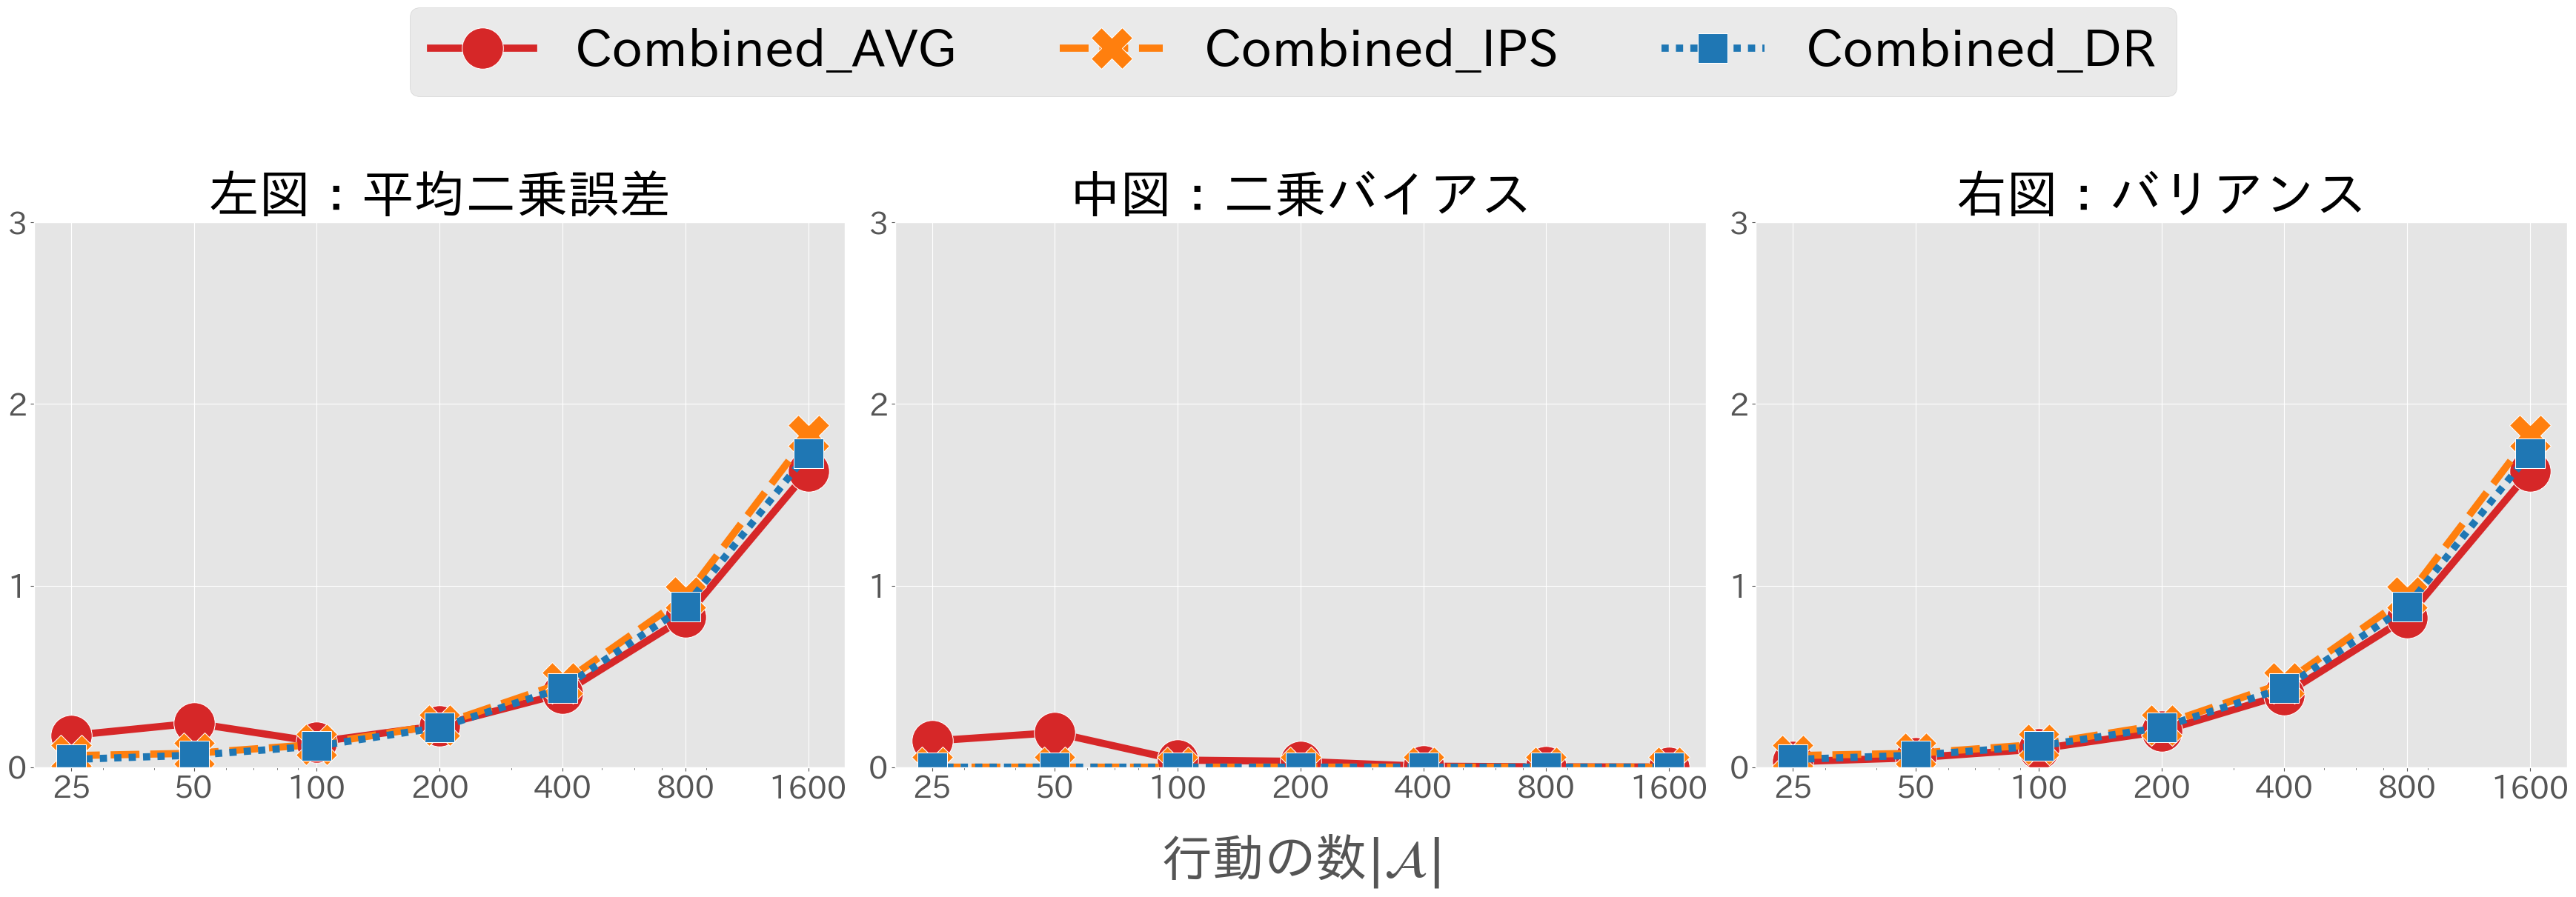

In [14]:
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange","tab:blue"],
        data=result_df_actions.query("est=='avg' or est == 'new_ips' or est == 'new_dr' ")
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 3.0)
    ax.set_yticks([0, 1, 2, 3])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Combined_AVG", "Combined_IPS", "Combined_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")